# CS 505 Homework 05:  Recurrent Neural Networks

#### Due Monday  11/27 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%. 

All homeworks will be scored with a maximum of 100 points; point values are given
for individual problems, and if parts of problems do not have point values given, they
will be counted equally toward the total for that problem. 

Note: This homework is a bit different from the first four in this class in that in some parts we are specified **what** you need to do for your solutions, but much less of the **how** you write the details of the code. There are three reasons for this:

- In a graduate level CS class, after four homeworks and two months of lectures, you should be well-equipped to work out the coding issues for yourself, and in general, going forward, this is how you will solve the kinds of problems presented here; 
- Suggestions for resources (mostly ML blogs) will be suggested; there are many resources, but these are from bloggers that I trust and have used in the past;
- I am expecting that you will make good use of chatGPT for help with the details of syntax and low-level organization of your code. There is often nothing very stimulating or informative about precisely what is the syntax needed for a particular kind of layer in a network, and rather than poke around on StackOverflow, chatGPT is particularly good at summarizing existing approaches to ML coding tasks. 

#### Submission Instructions

You must complete the homework by editing <b>this notebook</b> and submitting the following two files in Gradescope by the due date and time:

  - A file <code>HW05.ipynb</code> (be sure to select <code>Kernel -> Restart and Run All</code> before you submit, to make sure everything works); and
  - A file <code>HW05.pdf</code> created from the previous.
  
  For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine -- just make sure it is readable and no cell contents have been cut off. Make it easy to grade!
  
The date and time of your submission is the last file you submitted, so if your IPYNB file is submitted on time, but your PDF is late, then your submission is late. 

## Collaborators (5 pts)

Describe briefly but precisely

1. Any persons you discussed this homework with and the nature of the discussion;
2. Any online resources you consulted and what information you got from those resources; and
3. Any AI agents (such as chatGPT or CoPilot) or other applications you used to complete the homework, and the nature of the help you received. 

A few brief sentences is all that I am looking for here. 

Discussed the approach of Problem 1 - character level language model with another student in the class - Zach
Consulted the blog by Karpathy and the code present there. used chatGPT for syntax 

For problem 2 i consulted prof's lecture on Youtube and lecture slides. 
also consulted the blog linked and used ChatGPT to help convert the code from keras to pytorch whereever i got stuck 
i had got stuck in beam-search, perplexity part of the problem and i asked zach for help there. 

For problem 3, i heavily consulted chatGPT specially for 3C and optional. 
The prof had mentioned on Piazza that this was encouraged. 

In [1]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string




## Problem One:  Character-Level Generative Model (20 pts)

A basic character-level model has been provided on the class web site in the row for Lecture 14: 
<a href="https://www.cs.bu.edu/fac/snyder/cs505/CharacterLevelLSTM.ipynb">IPYNB</a>. Your first step is to download this and run it in Colab (or download the data file, which is in the CS 505 Data Directory and also linked on the web site, and run it on your local machine) and understand all its various features. Most of it is straight-forward at this point in the course, but the definition of the model is a bit messy, and you will need to read about LSTM layers in the Pytorch documents to really understand what it is doing and what the hyperparameters mean. 

Also take a look at the article "The Unreasonable Effectiveness of Recurrent Neural Networks" linked with lecture 14. 

For this problem, you will run this code on a dataset consisting of Java code files, which has been uploaded to the CS 505 Data Directory and also to the class web site: <a href="https://www.cs.bu.edu/fac/snyder/cs505/JavaFiles/">DIR</a>  Select some number of these files and concatenate them into one long text file, such that you have approximately 10-20K characters (if you have trouble running out of RAM you can use fewer, but try to get at least 10K). 

You will run the character-level model on this dataset. You may either cut and paste code into this notebook, or submit the file with your changes and output along with this notebook to Gradescope.

Your task is to get a character-level model that has not simply memorized the Java text file by overfitting, and does not do much other than spit out random characters (underfitting).  You will get the former if you simply run it for many epochs without any changes to the hyperparameters; you will get the latter if you run it only a few epochs. 

You should experiment with different hyperparameters, which in the notebook are indicated
by 

          <== something to play with

and try to get a model that seems to recognize typical Java syntax such as comments, matching parentheses, expressions, assignments, and formatting, but is not just repeating
exact text from the data file. Clearly, the number of epochs plays a crucial role, but I also want you to
experiment with the various hyperparameters to try to avoid overfitting. See my lectures on T 10/31 and Th 11/2 (recorded and on my YT channel) for the background to this.

Note that the code you will work from does not use validation and testing sets, nor does it calculate the accuracy, but only tracks the loss. The nature of the data sets for character-level models does not seem to lend itself to accuracy metrics, but you may wish to try this -- I have not found it to be useful, but have simply focussed on the output and "eyeballed" the results to determine how much they have generalized
from the data. 

Submit your notebook(s) to Gradescope as usual, and also provide a summary of your results in the next cell. 
 

Download and read the file 

In [2]:
with open("HashTableLPResizing.java", "r") as text_file:
    text = text_file.read()

text[:101]

'public class HashTableLPResizing {\n  \n  private final int neverUsed = -1;\n  private final int usedBut'

Info about the file 


Training a character-level language model on the provided Java file, "HashTableLPResizing.java," is an interesting project. This file appears to be a Java class implementation of a hash table with linear probing and dynamic resizing. The class includes various methods for inserting, deleting, checking membership, resizing the table, rehashing, and printing the table contents.

Training a character-level model on this code can help the model learn Java syntax, programming patterns specific to hash table implementations, and even stylistic nuances of code writing, like commenting and structuring.

The process involves feeding the model with the text of this Java file and allowing it to learn the patterns in the characters. The model will then be able to generate text that resembles Java code, potentially even synthesizing new code snippets that are syntactically correct and logically sound, based on the learned patterns.

This approach can be useful for understanding code structure, assisting in code completion, and even in educational settings to help new programmers understand coding patterns and practices. Remember, the effectiveness of the model will largely depend on the size and diversity of the training data. Since this is a single file, the scope of learning will be limited to the patterns and structures within this specific implementation.







In [48]:
print(f"Text is {len(text)} characters long.")

size = 10000

text = text[:size]

Text is 10000 characters long.


working with first 10k characters

In [4]:
chars_in_text = sorted(list(set(text)))
num_chars = len(chars_in_text)
print(f'There are {num_chars} characters in the text.')
print(f'Character set: {chars_in_text}.')

There are 75 characters in the text.
Character set: ['\n', ' ', '!', '"', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', 'A', 'B', 'E', 'F', 'H', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'W', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}'].


In [5]:
# Create functions mapping characters to integers and back

def char2int(c):
    return chars_in_text.index(c)

def int2char(i):
    return chars_in_text[i] 

In [6]:
sample_len = 75

# Creating lists that will hold our input and target sample sequences

input_seq_chars = []
target_seq_chars = []

for k in range(len(text)-sample_len+1):

    # Remove last character for input sequence
    input_seq_chars.append(text[k:k+sample_len-1])

    # Remove firsts character for target sequence
    target_seq_chars.append(text[k+1:k+sample_len])

# for i in range(5):
#     print(f'Input sequence:\n{input_seq_chars[i]}')
#     print(f'Target sequence:\n{target_seq_chars[i]}')
#     print()

In [7]:
input_seq = []
target_seq = []

for i in range(len(input_seq_chars)):
    input_seq.append( [char2int(ch) for ch in input_seq_chars[i]])
    target_seq.append([char2int(ch) for ch in target_seq_chars[i]])

print(input_seq[0])

[63, 67, 49, 59, 56, 50, 1, 50, 59, 48, 65, 65, 1, 33, 48, 65, 55, 42, 48, 49, 59, 52, 35, 39, 40, 52, 65, 56, 72, 56, 61, 54, 1, 73, 0, 1, 1, 0, 1, 1, 63, 64, 56, 68, 48, 66, 52, 1, 53, 56, 61, 48, 59, 1, 56, 61, 66, 1, 61, 52, 68, 52, 64, 43, 65, 52, 51, 1, 27, 1, 11, 15, 25, 0]


In [8]:
# convert an integer into a one-hot encoding of the given size (= number of characters)
def int2OneHot(X,size):

    def int2OneHot1(x,size=10):
        tmp = np.zeros(size)
        tmp[int(x)] = 1.0
        return tmp

    return np.array([ int2OneHot1(x, size) for x in X ]).astype('double')

int2OneHot( np.array([ 2,3,1,2,3,4 ]),10)

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [9]:
# do the same thing, but for a list/array of integers

def seq2OneHot(seq,size):
    return np.array([ int2OneHot(x, size) for x in seq ])

seq2OneHot( np.array([[ 2,3,1,2,3,4 ],[ 2,3,1,2,3,4 ],[ 2,3,1,2,3,4 ]]),10)

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])

In [10]:
# Convert our input sequences to one-hot form

input_seq = seq2OneHot(input_seq,size=num_chars)
input_seq.shape

(9926, 74, 75)

In [11]:
# Convert our target sequences to one-hot form

target_seq = seq2OneHot(target_seq,size=num_chars)
target_seq.shape

(9926, 74, 75)

In [12]:
input_seq = torch.Tensor(input_seq).type(torch.DoubleTensor)
target_seq = torch.Tensor(target_seq).type(torch.DoubleTensor)

In [13]:
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

ds = Basic_Dataset(input_seq,target_seq)

ds.__len__()

9926

In [14]:
batch_size = 128

data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [15]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# is_cuda = torch.cuda.is_available()
is_cuda = False

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [16]:
from os import device_encoding
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,dropout):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=dropout,batch_first=True)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        hidden_state_size = x.size(0)

        x = x.to(torch.double)

        h0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)
        c0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)

        self.lstm = self.lstm.double()

        self.fc1 = self.fc1.double()

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (hx,cx) = self.lstm(x, (h0,c0))

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc1(out)

        return out

In [17]:
# Instantiate the model with hyperparameters

model = Model(input_size=num_chars, output_size=num_chars, hidden_dim=25, n_layers=1,dropout=0)

print(model)

model = model.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=0)


Model(
  (lstm): LSTM(75, 25, batch_first=True)
  (fc1): Linear(in_features=25, out_features=75, bias=True)
)


100%|██████████| 50/50 [04:13<00:00,  5.08s/it]


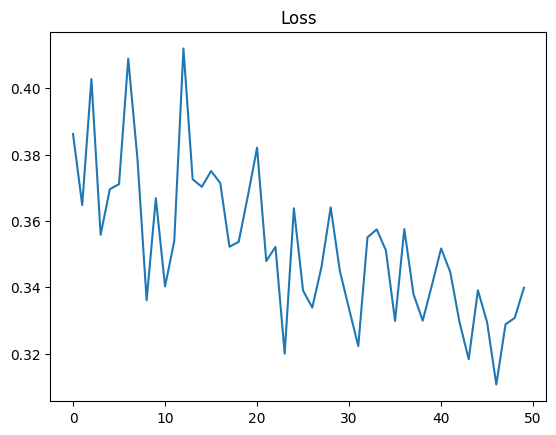

In [40]:
num_epochs = 50

losses = []

model.train()

for epoch in tqdm(range(num_epochs)):

    for input_seq_batch,target_seq_batch in tqdm(data_loader):
        input_seq_batch = input_seq_batch.to(device)
        target_seq_batch = target_seq_batch.to(device)
        optimizer.zero_grad()
        target_seq_hat = model(input_seq_batch)
        loss = loss_fn(target_seq_hat,target_seq_batch.view(-1,num_chars))
        loss.backward()
        optimizer.step()

    losses.append(loss.item())


plt.title('Loss')
plt.plot(losses)

In [41]:
def softmax_with_temperature(vec, temperature):
    sum_exp = sum(math.exp(x/temperature) for x in vec)
    return [math.exp(x/temperature)/sum_exp for x in vec]

print("Example of softmax with temperature.")
dist = [0.1, 0.3, 0.6]
print('distribution:',dist)
print(softmax_with_temperature(dist,0.01))
print(softmax_with_temperature(dist,0.1))
print(softmax_with_temperature(dist,0.2))
print(softmax_with_temperature(dist,0.3))
print(softmax_with_temperature(dist,1))
print(softmax_with_temperature(dist,10))

Example of softmax with temperature.
distribution: [0.1, 0.3, 0.6]
[1.9287498479637375e-22, 9.3576229688393e-14, 0.9999999999999064]
[0.006377460922442302, 0.04712341652466416, 0.9464991225528936]
[0.06289001324586753, 0.1709527801977903, 0.7661572065563421]
[0.12132647558421489, 0.23631170657656433, 0.6423618178392208]
[0.2583896517379799, 0.3155978333128144, 0.4260125149492058]
[0.3255767455856355, 0.3321538321280155, 0.3422694222863489]


In [42]:
temperature = 0.35

def predict(model, ch):

    # only look at last sample_len - 1 characters

    ch = ch[-(sample_len - 1):]

    # One-hot encoding our input to fit into the model
    ch = np.array([char2int(c) for c in ch])
    ch = np.array([int2OneHot(ch, num_chars)])
    ch = torch.from_numpy(ch).to(device)

    out = model(ch)

    # take the probability distribution of the last character in the sequence produced by the model
    prob = softmax_with_temperature(out[-1],temperature)

    # Choosing a character based on the probability distribution, with temperature
    char_ind = choice(list(range(num_chars)), p=prob)

    return int2char(char_ind)

#predict(model,"Of man's first disobedience, and the fruit o")
predict(model,"public class HashTableLPResiz")

'i'

In [43]:
def sample(model, out_len, start):
    model.eval() # eval mode
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [29]:
print(sample(model, 1000, "public class HashTableLPRes"))

public class HashTableLPResizing();
        A[i] = neverUsed;
    if(inResizingMode) {                                               // n that or f return trig
               // prime if(ANew[i] == neverUsed)
          if(A[i] == key) {
                     // next pric booloom] < 00) 
    for(i to ANew = -1;
  private int i; 
    int N = 0.59 
      , 797, 907, 979, 757, 737, 701, 701, 701, 709, 753, 887, 883, 887, 883, 881, 887, 887, 883, 871, 789, 781, 79, 87, 87, 87, 87, 17, 17, 17, 11, 17, 11, 131, 141, 151, 151, 163, 197, 199, 107, 109, 123,1129,1753,1189,1187,1753,1757,1781,1873,1873,1899,1889e
       // key table in rus insert = "+ "+i+"]: "); 
      else if(ANew[i] == neverUsed;   return trig && relsizen("ANew["+i+"]: " + A[i]); 
    }
        System.out.println("ANew["+i+"]: " + A[i]); 
    }
      for(i = hash(key,A.length); A[i] != neverUsed && remaining > 0; i = (i + 1) % ANew.length) {
        if(ANew[i] == neverUsed;   return trig
        private int K = A.length; 
     

In [24]:
# Result after 10 epochs 


public class HashTableLPResizing(); 

In [30]:
#Result after 25 epochs 

<!-- public class HashTableLPResizing();
        A[i] = neverUsed;
    if(inResizingMode) {                                               // n that or f return trig
               // prime if(ANew[i] == neverUsed)
          if(A[i] == key) {
                     // next pric booloom] < 00) 
    for(i to ANew = -1;
  private int i; 
    int N = 0.59 
      , 797, 907, 979, 757, 737, 701, 701, 701, 709, 753, 887, 883, 887, 883, 881, 887, 887, 883, 871, 789, 781, 79, 87, 87, 87, 87, 17, 17, 17, 11, 17, 11, 131, 141, 151, 151, 163, 197, 199, 107, 109, 123,1129,1753,1189,1187,1753,1757,1781,1873,1873,1899,1889e
       // key table in rus insert = "+ "+i+"]: "); 
      else if(ANew[i] == neverUsed;   return trig && relsizen("ANew["+i+"]: " + A[i]); 
    }
        System.out.println("ANew["+i+"]: " + A[i]); 
    }
      for(i = hash(key,A.length); A[i] != neverUsed && remaining > 0; i = (i + 1) % ANew.length) {
        if(ANew[i] == neverUsed;   return trig
        private int K = A.length;  -->

In [32]:
public class HashTableLPResizing();
        A[i] = neverUsed;
    if(inResizingMode) {                                               // n that or f return trig
               // prime if(ANew[i] == neverUsed)
          if(A[i] == key) {
                     // next pric booloom] < 00) 
    for(i to ANew = -1;
  private int i; 
    int N = 0.59 
      , 797, 907, 979, 757, 737, 701, 701, 701, 709, 753, 887, 883, 887, 883, 881, 887, 887, 883, 871, 789, 781, 79, 87, 87, 87, 87, 17, 17, 17, 11, 17, 11, 131, 141, 151, 151, 163, 197, 199, 107, 109, 123,1129,1753,1189,1187,1753,1757,1781,1873,1873,1899,1889e
       // key table in rus insert = "+ "+i+"]: "); 
      else if(ANew[i] == neverUsed;   return trig && relsizen("ANew["+i+"]: " + A[i]); 
    }
        System.out.println("ANew["+i+"]: " + A[i]); 
    }
      for(i = hash(key,A.length); A[i] != neverUsed && remaining > 0; i = (i + 1) % ANew.length) {
        if(ANew[i] == neverUsed;   return trig
        private int K = A.length; 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

In [37]:
# Output after 50 epochs

In [38]:
print(sample(model, 1000, "public class HashTableLPRes"))

public class HashTableLPResizing H = new HashTableLPResizing(); 
    H.printTables();
     T.insert( {
    thins giner into the slot isEmpt intauctor gis 
  
  private int nextSlot = 0;          // pld tubl , e aretiach (Stric sea keyimetraty thesimple one on ner rehashing("+key+"Ne"""); 
        System.out.println("A["+i+"]: " + A[i]); 
    }
      if(p, N == 0);   
    ,1909,1729,1701,1701,1707,1727,1753, 757, 763, 753, 761, 733 
    , 737, 797, 701, 709, 723, 733, 739, 733 
    , 73, 8, 
  p, 66, 67, 71, 87, 673, 619, 619, 643, 649, 643, 653, 2679, 643, 653, 649, 653, 649, 643, 649, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 601, 607, 619, 643, 641, 643, 653, 2679, 653, 653, 653, 653, 601, 607, 619, 641, 641, 643, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 601, 607, 643, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 601, 2067, 2089, 2273, 2111, 2377, 2387, 

In [39]:
public class HashTableLPResizing H = new HashTableLPResizing(); 
    H.printTables();
     T.insert( {
    thins giner into the slot isEmpt intauctor gis 
  
  private int nextSlot = 0;          // pld tubl , e aretiach (Stric sea keyimetraty thesimple one on ner rehashing("+key+"Ne"""); 
        System.out.println("A["+i+"]: " + A[i]); 
    }
      if(p, N == 0);   
    ,1909,1729,1701,1701,1707,1727,1753, 757, 763, 753, 761, 733 
    , 737, 797, 701, 709, 723, 733, 739, 733 
    , 73, 8, 
  p, 66, 67, 71, 87, 673, 619, 619, 643, 649, 643, 653, 2679, 643, 653, 649, 653, 649, 643, 649, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 601, 607, 619, 643, 641, 643, 653, 2679, 653, 653, 653, 653, 601, 607, 619, 641, 641, 643, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 601, 607, 643, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 653, 601, 2067, 2089, 2273, 2111, 2377, 2387,

SyntaxError: unterminated triple-quoted string literal (detected at line 13) (934255942.py, line 6)

In [44]:
# Output after 100 epochs

In [45]:
print(sample(model, 1000, "public class HashTableLPRes"))

public class HashTableLPResizing {
      // move one key fullrger A = new latic booch the 
      }
      // move one key from old table and return the on that into ANew
  // note that duplicates may be inserted into A because of a deletion of a key higher resizing mode
  // and arrayFac old table
  
  private void printTables() {
    printTable(); 
    if(inResizingMode)
      printTableNew();
    System.out.println("N = " + N + "\n"); 
  }
  
  
  private int N = 0;                                                          // numbert(i + i) 
    int i; 
    for(i = hash(key,A.length); A[i] != neverUsed && remaining > 0; i = (i + 1) % ANew.length) {
        if(ANew[i] == key) {
          if(ANew[i] == key) {
          A[i] = usedButEmpty; 
        --N;
        
      }
      if(ANew[i] == key) {
          ANew[i] = usedButEmpty; 
          --N;
        
      }
      if(ANew[i] == key) {
          A[i] = usedButEmpty; 
        --N;
        return NLPHelper(p,lo,mid-1);
      else
      

In [47]:
public class HashTableLPResizing {
      // move one key fullrger A = new latic booch the 
      }
      // move one key from old table and return the on that into ANew
  // note that duplicates may be inserted into A because of a deletion of a key higher resizing mode
  // and arrayFac old table
  
  private void printTables() {
    printTable(); 
    if(inResizingMode)
      printTableNew();
    System.out.println("N = " + N + "\n"); 
  }
  
  
  private int N = 0;                                                          // numbert(i + i) 
    int i; 
    for(i = hash(key,A.length); A[i] != neverUsed && remaining > 0; i = (i + 1) % ANew.length) {
        if(ANew[i] == key) {
          if(ANew[i] == key) {
          A[i] = usedButEmpty; 
        --N;
        
      }
      if(ANew[i] == key) {
...
        --N;
        return NLPHelper(p,lo,mid-1);
      else

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

So we can see that even after 100 epochs the model cant produce error free code 

Code Outline : 

Text Preprocessing: The script starts by truncating the input text to a fixed size and creates mappings (char2int, int2char) to convert characters to integers and vice versa.

Sequence Creation: It generates input and target sequences for training, where each input sequence is mapped to a target sequence offset by one character.

One-Hot Encoding: The sequences are converted into one-hot encoded format, which is a standard way to represent categorical data for neural networks.

Dataset and DataLoader: A custom dataset class Basic_Dataset is defined for the input and target sequences, and a DataLoader is used for batching and shuffling the data.

Model Definition: The Model class defines an LSTM-based neural network with a fully connected layer for output.

Training Loop: The model is trained over a number of epochs, using cross-entropy loss and Adam optimizer.

Temperature-based Sampling: A softmax function with temperature is used to generate a probability distribution for the next character, which adds variability to the generated text.

Text Generation: The sample function generates text by repeatedly predicting the next character based on the previously generated characters.

Various hyper-parameters in the code 

size: The size of the text used for training, truncating the original text to this length.

sample_len: Length of each sample sequence used for training.

batch_size: Number of samples per batch in training.

num_epochs: The number of training epochs, or full passes through the dataset.

hidden_dim: The dimensionality of the hidden state in the LSTM.

n_layers: The number of layers in the LSTM.

dropout: The dropout rate for regularization in the LSTM.

lr (learning rate): The learning rate for the Adam optimizer.

weight_decay: The weight decay (L2 penalty) parameter for the optimizer.

temperature: Used in temperature-based sampling for text generation, affecting the randomness of the predictions.



Values chosen for various hyper-paramters 

<!-- size: 10000 (used to truncate the text for training)
sample_len: 75 (length of each training sample sequence)
batch_size: 128 (number of samples per batch in training)
num_epochs: 50 (number of training epochs)
hidden_dim: 25 (dimensionality of the hidden state in the LSTM)
n_layers: 1 (number of LSTM layers)
dropout: 0 (dropout rate for regularization in the LSTM)
lr (learning rate): 0.01 (learning rate for the Adam optimizer)
weight_decay: 0 (weight decay or L2 penalty for the optimizer)
temperature: 0.35 (used in temperature-based sampling for text generation) -->


In [50]:
# Values chosen for various hyper-parameters 
# size: 10000 (used to truncate the text for training)
# sample_len: 75 (length of each training sample sequence)
# batch_size: 128 (number of samples per batch in training)
# num_epochs: 50 (number of training epochs)
# hidden_dim: 25 (dimensionality of the hidden state in the LSTM)
# n_layers: 1 (number of LSTM layers)
# dropout: 0 (dropout rate for regularization in the LSTM)
# lr (learning rate): 0.01 (learning rate for the Adam optimizer)
# weight_decay: 0 (weight decay or L2 penalty for the optimizer)
# temperature: 0.35 (used in temperature-based sampling for text generation)

It would have been preferable to be able to use a bigger 'size' 

sample_len of 75 is good enough 

for batch_size, i tried 128 and 64. Could have tried 32 or lower if i had more time. 

num_epochs : tried till 100 epochs. Based on the graph, it doesnt seem like training further will help. 

hidden_dim : This might be low for complex tasks. Increasing it can capture more complex patterns but increases computational cost.

n_layers : More layers can model more complex patterns, but also increase the risk of overfitting and computational cost.

dropout : didnt have the time to experiment with this 

lr : standard values 

temperature : tried various values in the range .3 -1 : this worked well 

### Your analysis

Please describe your experiments and cut and paste various outputs to show how the model performed at
various numbers of epochs and with various hyperparameters. What characteristics of Java was it able to learn? What did it not learn? The article "The Unreasonable ..." does a nice job of showing this kind of behavior as the number of epochs increases, and you might look at it before writing your answer here. 






Done above 

## Problem Two:  Word-Level Generative Model (40 pts)

In this problem you will write another generative model, as you did in HW 03, but this time you will use an LSTM network, GloVe word embeddings, and beam search. 

Before you start, read the following blog post to see the core ideas involved in creating a generative model using word embeddings:

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

You may also wish to consult with chatGPT about how to develop this kind of model in Pytorch.

The requirements for this problem are as follows (they mostly consist of the extensions proposed at
the end of the blog post linked above):

- Develop your code in Pytorch, not Keras
- Use the novel *Persuation* by Jane Austen as your training data (available through the NLTK, you can just grab the sentences using `nltk.corpus.gutenberg.sents('austen-persuasion.txt')`); if you have trouble with RAM you will need to cut down the number of sentences (perhaps by eliminating the longest sentences as well, see next point). 
- Develop a sentence-level model by padding sentences to the maximum sentence length in the novel (if this seems extreme, you may wish to delete a small number of the longest sentences to reduce the maximum length). Surround your data sentences with `<s>` and `</s>` and your model should generate one sentence at a time (as you did in HW 03), i.e., it should stop if it generates the `</s>` token. 
- Use pretrained GLoVe embeddings with dimension 200, and update them (refine by training further) on the sentences in the novel; if you have trouble with RAM you may use a smaller dimension. 
- Experiment with the hyperparameters (sample length, number of layers, uni- or bi-directional, weight_decay, dropout, number of epochs, temperature of the softmax, etc.) as you did in Problem One to find the "sweet spot" where you are generating interesting-looking sentences but not simply repeating sentences from the data. You may want to try adding more linear layers on top to pick the most likely next word. 
- Generate sentences using Beam Search, which we describe below. 

Your solution should be the code, samples of sentences generated with their score (described below), and your description of the investigation of various hyperparameters, and what strategy ended up seeming to generate the most realistic sentences that were not simply a repeat of sentences in the data. 
 

### Beam Search

Beam search was described, and example shown, in Lecture 14. Here is a brief pseudo-code explaination of what
you need to do:

1. Develop your code as described above so that it can generate single sentences;
2. Copy enough of your code over from HW 03 so that you can calculate the perplexity of
        sentences (using the entire novel, or perhaps even a number of Jane Austen's novels as
        the data source). As an alternative, you may wish to do this separately, store the nested dictionary
        using Pickle, and load it here. 
3. Calculate the probability distribution of sentences in your data source that you used in the previous step, similar to what you did at the end of HW 01. 
4. Create a "goodness function" which estimates the quality of a sentence as the perplexity times the probability of its length.  This will be applied to all sequences of words, and not just sentences, but as a first approximation this is a way to attempt to make the distribution of sentence lengths similar to that in the novel.
5. Follow the description in slide 7 of Lecture 14 to generate until you have 10 finished sentences. Print these out with their perplexity, probability of their length, and the combined goodness metric. 

In [51]:
# Code here 
import nltk 
nltk.download('gutenberg')
from nltk.corpus import gutenberg
sentences = gutenberg.sents('austen-persuasion.txt')


[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/gauravbindra/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [52]:
print(sentences[0])

['[', 'Persuasion', 'by', 'Jane', 'Austen', '1818', ']']


In [53]:
count = 0
for sentence in sentences: 
    print(sentence)
    count+=1
    if count==5:
        break

['[', 'Persuasion', 'by', 'Jane', 'Austen', '1818', ']']
['Chapter', '1']
['Sir', 'Walter', 'Elliot', ',', 'of', 'Kellynch', 'Hall', ',', 'in', 'Somersetshire', ',', 'was', 'a', 'man', 'who', ',', 'for', 'his', 'own', 'amusement', ',', 'never', 'took', 'up', 'any', 'book', 'but', 'the', 'Baronetage', ';', 'there', 'he', 'found', 'occupation', 'for', 'an', 'idle', 'hour', ',', 'and', 'consolation', 'in', 'a', 'distressed', 'one', ';', 'there', 'his', 'faculties', 'were', 'roused', 'into', 'admiration', 'and', 'respect', ',', 'by', 'contemplating', 'the', 'limited', 'remnant', 'of', 'the', 'earliest', 'patents', ';', 'there', 'any', 'unwelcome', 'sensations', ',', 'arising', 'from', 'domestic', 'affairs', 'changed', 'naturally', 'into', 'pity', 'and', 'contempt', 'as', 'he', 'turned', 'over', 'the', 'almost', 'endless', 'creations', 'of', 'the', 'last', 'century', ';', 'and', 'there', ',', 'if', 'every', 'other', 'leaf', 'were', 'powerless', ',', 'he', 'could', 'read', 'his', 'own', 'his

In [55]:
max_len = 0
for sentence in sentences: 
    sentence_len = len(sentence)
    if sentence_len > max_len:
        max_len = sentence_len

    

In [56]:
max_len

217

The max length is 217

In [57]:
len(sentences)

3747

In [58]:
sentence_with_spaces = [word.replace('–', ' ') for word in sentence]

In [59]:
# def clean_sentence(sentence):
#     # Replace dashes with a white space
#     sentence_with_spaces = [word.replace('–', ' ') for word in sentence]

#     # Further cleaning: lowercasing and removing punctuation
#     cleaned = [word.lower().strip(string.punctuation) for word in sentence_with_spaces if word.isalpha()]
#     return cleaned



earlier had it removing punctuations as well, but after seeing the sentences generated, realised that it wasnt needed

In [60]:
import string

def clean_sentence(sentence):
    # Replace dashes with a white space
    sentence_with_spaces = [word.replace('–', ' ') for word in sentence]

    # Further cleaning: lowercasing but keeping punctuation
    cleaned = [word.lower() for word in sentence_with_spaces if word.isalpha() or word in string.punctuation]
    return cleaned

In [61]:
cleaned_sentences = [clean_sentence(sentence) for sentence in sentences]

In [62]:
print(cleaned_sentences[2])
print(sentences[2])

['sir', 'walter', 'elliot', ',', 'of', 'kellynch', 'hall', ',', 'in', 'somersetshire', ',', 'was', 'a', 'man', 'who', ',', 'for', 'his', 'own', 'amusement', ',', 'never', 'took', 'up', 'any', 'book', 'but', 'the', 'baronetage', ';', 'there', 'he', 'found', 'occupation', 'for', 'an', 'idle', 'hour', ',', 'and', 'consolation', 'in', 'a', 'distressed', 'one', ';', 'there', 'his', 'faculties', 'were', 'roused', 'into', 'admiration', 'and', 'respect', ',', 'by', 'contemplating', 'the', 'limited', 'remnant', 'of', 'the', 'earliest', 'patents', ';', 'there', 'any', 'unwelcome', 'sensations', ',', 'arising', 'from', 'domestic', 'affairs', 'changed', 'naturally', 'into', 'pity', 'and', 'contempt', 'as', 'he', 'turned', 'over', 'the', 'almost', 'endless', 'creations', 'of', 'the', 'last', 'century', ';', 'and', 'there', ',', 'if', 'every', 'other', 'leaf', 'were', 'powerless', ',', 'he', 'could', 'read', 'his', 'own', 'history', 'with', 'an', 'interest', 'which', 'never', 'failed', '.']
['Sir', 

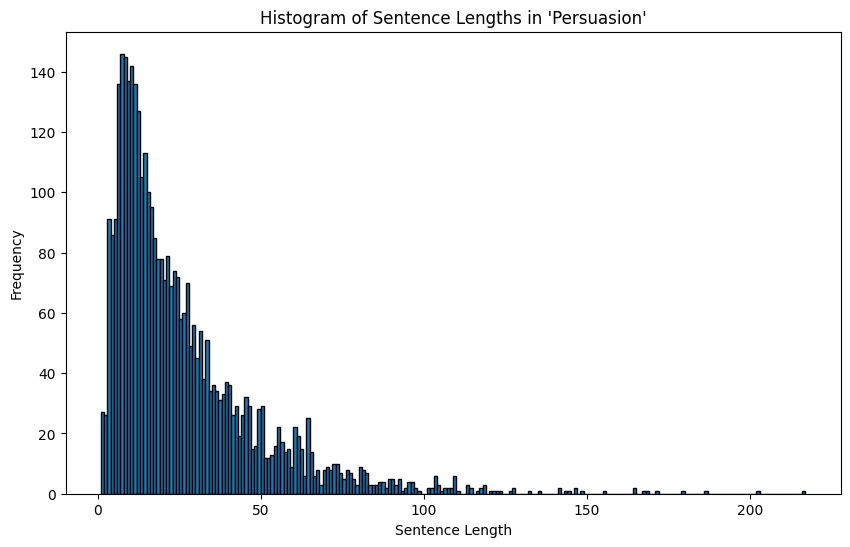

In [63]:
sentence_lengths = [len(sentence) for sentence in cleaned_sentences]
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths) + 1), edgecolor='black')
plt.title("Histogram of Sentence Lengths in 'Persuasion'")
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [64]:
count = 0
for sentence in sentences: 
    print(sentence)
    count+=1
    if count==5:
        break

['[', 'Persuasion', 'by', 'Jane', 'Austen', '1818', ']']
['Chapter', '1']
['Sir', 'Walter', 'Elliot', ',', 'of', 'Kellynch', 'Hall', ',', 'in', 'Somersetshire', ',', 'was', 'a', 'man', 'who', ',', 'for', 'his', 'own', 'amusement', ',', 'never', 'took', 'up', 'any', 'book', 'but', 'the', 'Baronetage', ';', 'there', 'he', 'found', 'occupation', 'for', 'an', 'idle', 'hour', ',', 'and', 'consolation', 'in', 'a', 'distressed', 'one', ';', 'there', 'his', 'faculties', 'were', 'roused', 'into', 'admiration', 'and', 'respect', ',', 'by', 'contemplating', 'the', 'limited', 'remnant', 'of', 'the', 'earliest', 'patents', ';', 'there', 'any', 'unwelcome', 'sensations', ',', 'arising', 'from', 'domestic', 'affairs', 'changed', 'naturally', 'into', 'pity', 'and', 'contempt', 'as', 'he', 'turned', 'over', 'the', 'almost', 'endless', 'creations', 'of', 'the', 'last', 'century', ';', 'and', 'there', ',', 'if', 'every', 'other', 'leaf', 'were', 'powerless', ',', 'he', 'could', 'read', 'his', 'own', 'his

In [65]:
type(cleaned_sentences)

list

In [66]:
len(cleaned_sentences)

3747

In [70]:
count = 0
for sentence in cleaned_sentences: 
    sentence_len = len(sentence)
    if sentence_len > 55:
        count+=1

In [71]:
count

392

In [69]:
392/3747

0.15585801974913263

Had this at 45 when pundctuations were not there. Changed to incorporate them

In [72]:
filtered_sentences = [sentence for sentence in cleaned_sentences if len(sentence) <= 55]

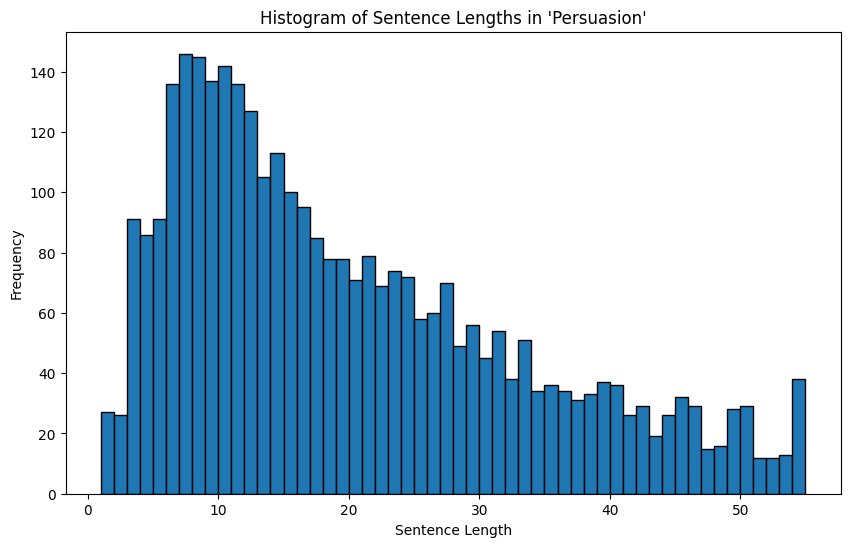

In [73]:
sentence_lengths = [len(sentence) for sentence in filtered_sentences]
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths) + 1), edgecolor='black')
plt.title("Histogram of Sentence Lengths in 'Persuasion'")
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [74]:
# 450/3747

In [75]:
# Define the padding token
pad_token = "<PAD>"
start_token = "<s>"
end_token = "</s>"
unknown_token = "<UNK>"

# Pad each sentence to a length of 55
padded_sentences = [[start_token] + sentence + [end_token] + [pad_token] * (55 - len(sentence)) 
    for sentence in filtered_sentences]


In [76]:
# Example: Check the first padded sentence
print(padded_sentences[2])

['<s>', 'this', 'was', 'the', 'page', 'at', 'which', 'the', 'favourite', 'volume', 'always', 'opened', ':', '</s>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [77]:
# Initialize a dictionary for the vocabulary
vocabulary = {
    pad_token: 0,
    start_token: 1,
    end_token: 2,
    unknown_token :3
}

# Starting index for actual words
word_index = 4

# Loop through each sentence and add each unique word to the vocabulary
for sentence in padded_sentences:
    for word in sentence:
        if word not in vocabulary:
            vocabulary[word] = word_index
            word_index += 1

# Now, 'vocabulary' is a dictionary mapping words to their integer index
print("Vocabulary size:", len(vocabulary))

Vocabulary size: 4652


In [81]:
vocabulary['page']

14

designed to convert each sentence in sentences into a list of integers based on the vocabulary dictionary


In [79]:
def vectorize_sentences(sentences, vocabulary):
    vectorized_data = []
    unk_index = vocabulary.get("<UNK>")  # Index for unknown words

    for sentence in sentences:
        vectorized_sentence = [vocabulary.get(word, unk_index) for word in sentence]
        vectorized_data.append(vectorized_sentence)

    return vectorized_data

# Vectorizing your sentences
vectorized_sentences = vectorize_sentences(padded_sentences, vocabulary)

In [80]:
len(vectorized_sentences[2])
# vectorized_sentences[2]


57

In [82]:
len(padded_sentences[2])
# padded_sentences[2]

57

In [85]:
# use glove embeddings

converts a GloVe (Global Vectors for Word Representation) model file into a Word2Vec format

In [83]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file ='/Users/gauravbindra/desktop/NLP/hw05/glove.6B.200d.txt'
word2vec_output_file = 'glove.6B.200d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

/var/folders/3f/x95cmnkn57s5pfth5lygr5k00000gn/T/ipykernel_81711/3076318043.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 200)

In [84]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.200d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.6978678107261658)]


creates an embedding matrix that maps your vocabulary to the GloVe embeddings

In [86]:
#Creating the embedding matrix 

import numpy as np

embedding_dim = 200  # Dimension of GloVe vectors
vocab_size = len(vocabulary)  # Your vocabulary size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in vocabulary.items():
    if word in model:
        # Add the GloVe word embedding to the matrix
        embedding_matrix[idx] = model[word]
    else:
        # Initialize with random or zero vector for words not found
        embedding_matrix[idx] = np.random.randn(embedding_dim)

In [87]:
len(embedding_matrix)
# 4538 X 200

4652

In [88]:
import torch
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix,num_layers=2):
        super(LSTMLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Optionally freeze the embeddings
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        out = self.fc(lstm_out)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.num_layers, batch_size, self.hidden_dim).zero_())
        return hidden

# Parameters
vocab_size = len(vocabulary)  # Size of your vocabulary
embedding_dim = 200  # Dimension of GloVe embeddings
hidden_dim = 256  # Number of features in the hidden state of the LSTM

# Model Initialization
model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim, embedding_matrix)

In [89]:
import torch.optim as optim

# Assuming 'model' is the instance of your model class
pad_index=0
# Loss Function
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [92]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch

class TextDataset(Dataset):
    def __init__(self, vectorized_sentences):
        self.data = vectorized_sentences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)  # Input sequence (all but last word)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)   # Target sequence (all but first word)
        return x, y

# Assuming 'vectorized_sentences' is your list of vectorized and padded sentences
dataset = TextDataset(vectorized_sentences)

# Splitting the dataset
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
batch_size = 64  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [93]:
# import torch


# num_epochs = 10  # Number of training epochs

# for epoch in tqdm(range(num_epochs)):
#     model.train()  # Set model to training mode
#     hidden = model.init_hidden(batch_size)  # Initialize hidden state

#     for inputs, targets in train_loader:
#         hidden = tuple([each.data for each in hidden])  # Detach hidden state

#         optimizer.zero_grad()  # Zero the gradients
#         outputs, hidden = model(inputs, hidden)  # Forward pass
#         loss = criterion(outputs.transpose(1, 2), targets)  # Compute loss
#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update weights

#     # Validation loop
#     model.eval()  # Set model to evaluation mode
#     with torch.no_grad():
#         val_hidden = model.init_hidden(batch_size)
#         val_loss = 0
#         for inputs, targets in val_loader:
#             val_hidden = tuple([each.data for each in val_hidden])
#             outputs, val_hidden = model(inputs, val_hidden)
#             val_loss += criterion(outputs.transpose(1, 2), targets).item()

#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Validation Loss: {val_loss/len(val_loader)}")

In [94]:
num_epochs = 30  # Set the number of epochs

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    total_loss = 0

    for inputs, targets in train_loader:
        hidden = model.init_hidden(inputs.size(0))  # Initialize hidden state
        optimizer.zero_grad()  # Zero the gradients

        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs.transpose(1, 2), targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            val_hidden = model.init_hidden(inputs.size(0))
            outputs, val_hidden = model(inputs, val_hidden)
            val_loss = criterion(outputs.transpose(1, 2), targets)
            total_val_loss += val_loss.item()

    # Print average training and validation loss
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {total_val_loss/len(val_loader)}')

  3%|▎         | 1/30 [00:37<18:20, 37.96s/it]

Epoch 1/30, Training Loss: 6.611564004743421, Validation Loss: 6.040038049221039


  7%|▋         | 2/30 [01:12<16:40, 35.72s/it]

Epoch 2/30, Training Loss: 5.96250429668942, Validation Loss: 6.004546344280243


 10%|█         | 3/30 [01:49<16:23, 36.42s/it]

Epoch 3/30, Training Loss: 5.910895592457539, Validation Loss: 5.9863440990448


 13%|█▎        | 4/30 [02:23<15:27, 35.68s/it]

Epoch 4/30, Training Loss: 5.878444207681192, Validation Loss: 5.978936672210693


 17%|█▋        | 5/30 [02:57<14:29, 34.79s/it]

Epoch 5/30, Training Loss: 5.860545416136046, Validation Loss: 5.969632208347321


 20%|██        | 6/30 [03:30<13:42, 34.27s/it]

Epoch 6/30, Training Loss: 5.842778811583647, Validation Loss: 5.965262949466705


 23%|██▎       | 7/30 [04:01<12:45, 33.30s/it]

Epoch 7/30, Training Loss: 5.80839577236691, Validation Loss: 5.9088321924209595


 27%|██▋       | 8/30 [04:33<12:00, 32.73s/it]

Epoch 8/30, Training Loss: 5.736797242551236, Validation Loss: 5.8539857268333435


 30%|███       | 9/30 [05:09<11:48, 33.75s/it]

Epoch 9/30, Training Loss: 5.668054387376115, Validation Loss: 5.800485193729401


 33%|███▎      | 10/30 [05:43<11:16, 33.83s/it]

Epoch 10/30, Training Loss: 5.5935151125933675, Validation Loss: 5.7146897315979


 37%|███▋      | 11/30 [06:16<10:39, 33.68s/it]

Epoch 11/30, Training Loss: 5.497283883996912, Validation Loss: 5.619724094867706


 40%|████      | 12/30 [06:51<10:12, 34.03s/it]

Epoch 12/30, Training Loss: 5.399263884570147, Validation Loss: 5.539345145225525


 43%|████▎     | 13/30 [07:20<09:11, 32.43s/it]

Epoch 13/30, Training Loss: 5.312443604340425, Validation Loss: 5.461858570575714


 47%|████▋     | 14/30 [07:50<08:28, 31.78s/it]

Epoch 14/30, Training Loss: 5.225260657233161, Validation Loss: 5.392232835292816


 50%|█████     | 15/30 [08:20<07:47, 31.14s/it]

Epoch 15/30, Training Loss: 5.150775277936781, Validation Loss: 5.331539571285248


 53%|█████▎    | 16/30 [08:49<07:09, 30.67s/it]

Epoch 16/30, Training Loss: 5.076616441881335, Validation Loss: 5.277029871940613


 57%|█████▋    | 17/30 [09:19<06:35, 30.39s/it]

Epoch 17/30, Training Loss: 5.009884537877263, Validation Loss: 5.23568320274353


 60%|██████    | 18/30 [09:49<06:04, 30.41s/it]

Epoch 18/30, Training Loss: 4.951681833009462, Validation Loss: 5.203372895717621


 63%|██████▎   | 19/30 [10:23<05:45, 31.37s/it]

Epoch 19/30, Training Loss: 4.89495580260818, Validation Loss: 5.170692622661591


 67%|██████▋   | 20/30 [10:53<05:11, 31.12s/it]

Epoch 20/30, Training Loss: 4.844646041457717, Validation Loss: 5.138916254043579


 70%|███████   | 21/30 [11:31<04:56, 32.98s/it]

Epoch 21/30, Training Loss: 4.798003789540884, Validation Loss: 5.113717794418335


 73%|███████▎  | 22/30 [22:46<30:06, 225.85s/it]

Epoch 22/30, Training Loss: 4.749488985216296, Validation Loss: 5.090490818023682


 77%|███████▋  | 23/30 [23:19<19:35, 167.86s/it]

Epoch 23/30, Training Loss: 4.705512201463854, Validation Loss: 5.071631073951721


 80%|████████  | 24/30 [23:51<12:41, 126.98s/it]

Epoch 24/30, Training Loss: 4.6623967918189795, Validation Loss: 5.05565071105957


 83%|████████▎ | 25/30 [24:22<08:11, 98.25s/it] 

Epoch 25/30, Training Loss: 4.623549577352163, Validation Loss: 5.037358045578003


 87%|████████▋ | 26/30 [36:30<19:08, 287.22s/it]

Epoch 26/30, Training Loss: 4.582103355510815, Validation Loss: 5.015509188175201


 90%|█████████ | 27/30 [37:15<10:43, 214.61s/it]

Epoch 27/30, Training Loss: 4.544340816704002, Validation Loss: 5.002393543720245


 93%|█████████▎| 28/30 [37:48<05:20, 160.17s/it]

Epoch 28/30, Training Loss: 4.507374505738954, Validation Loss: 4.998869895935059


 97%|█████████▋| 29/30 [38:19<02:01, 121.35s/it]

Epoch 29/30, Training Loss: 4.471399784088135, Validation Loss: 4.98656302690506


100%|██████████| 30/30 [38:49<00:00, 77.65s/it] 

Epoch 30/30, Training Loss: 4.435467127207163, Validation Loss: 4.970628440380096


30 epochs was enough without the punctuation but for this more training will be helpful. Dont have the time to train more rn 

In [96]:
model.eval()  # Set the model to evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient computations
    for inputs, targets in test_loader:
        hidden = model.init_hidden(inputs.size(0))  # Initialize hidden state
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs.transpose(1, 2), targets)  # Calculate loss
        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {average_test_loss}')

Average Test Loss: 5.018877923488617


In [100]:
# import torch

# def generate_sentence(model, seed_text, max_length, vocab, idx_to_word):
#     model.eval()  # Evaluation mode
#     hidden = model.init_hidden(1)  # Initialize hidden state for single sequence

#     current_sequence = [vocab.get(word, vocab['<UNK>']) for word in seed_text.split()]  # Handle unknown words
#     generated_sentence = seed_text

#     for _ in range(max_length - len(current_sequence)):
#         # Convert current_sequence to PyTorch tensor
#         sequence_tensor = torch.tensor([current_sequence], dtype=torch.long)
        
#         # Get model prediction
#         with torch.no_grad():
#             output, hidden = model(sequence_tensor, hidden)

#         # Get the last word of the output
#         last_word_logits = output[0, -1]
#         predicted_index = torch.argmax(last_word_logits).item()
#         predicted_word = idx_to_word[predicted_index]

#         if predicted_word == '<\s>':  # Assuming you have an end token
#             break

#         generated_sentence += ' ' + predicted_word
#         current_sequence.append(predicted_index)
#         current_sequence = current_sequence[1:]  # Move the window

#     return generated_sentence

This code doesnt have randomness, predicts the same word everytime 

In [104]:
import torch
import torch.nn.functional as F
import numpy as np

def generate_sentence(model, seed_text, max_length, vocab, idx_to_word, temperature=1.0):
    model.eval()  # Evaluation mode
    hidden = model.init_hidden(1)  # Initialize hidden state for single sequence

    current_sequence = [vocab.get(word, vocab['<UNK>']) for word in seed_text.split()]
    generated_sentence = seed_text

    for _ in range(max_length - len(current_sequence)):
        sequence_tensor = torch.tensor([current_sequence], dtype=torch.long)
        
        with torch.no_grad():
            output, hidden = model(sequence_tensor, hidden)

        # Apply softmax and sample from the distribution
        probabilities = F.softmax(output[0, -1] / temperature, dim=0).cpu().numpy()
        predicted_index = np.random.choice(len(probabilities), p=probabilities)
        predicted_word = idx_to_word[predicted_index]

        if predicted_word == '</s>':
            break

        generated_sentence += ' ' + predicted_word
        current_sequence.append(predicted_index)
        current_sequence = current_sequence[1:]

    return generated_sentence

This has randomness as seen from the Sentence outputs below 

In [105]:
idx_to_word = {idx: word for word, idx in vocabulary.items()}

In [106]:
seed_texts = ["<s>", "<s> the croft", "<s> the hill", "<s> the", "<s> the" , "<s> the", 
              "<s> the", "<s> the", "<s> the", "<s> the", "<s> the"]

generated_sentences = []

for seed in seed_texts:
    sentence = generate_sentence(model, seed, 45, vocabulary, idx_to_word)
    generated_sentences.append(sentence)

for i, sentence in enumerate(generated_sentences, 1):
    print(f"Sentence {i}: {sentence}")

Sentence 1: <s> no there might her most there of their life .
Sentence 2: <s> the croft almost also she considered years in again : in each of the smile as seriously wants as intercourse beyond ; he is now , which sensations my more of those , brilliancy her wife how .
Sentence 3: <s> the hill and shame !
Sentence 4: <s> the credit park in fields at an soon
Sentence 5: <s> the intervals were finding by evening birth each life as not be claim
Sentence 6: <s> the to instance myself to give
Sentence 7: <s> the invitation object are an point .
Sentence 8: <s> the more view and her had intended a order to see every .
Sentence 9: <s> the historian which had difficult advantage to model twice , fix the in visits , nothing were compliance again ; but i must be longer , has soon my tone ; she could regard to plain to home .
Sentence 10: <s> the few staying of home acquaintance , not never have been afraid since an interchange , and gave and laura to gratify him
Sentence 11: <s> the almost of po

Example of output when trained without the punctuation 

In [179]:
seed_texts = ["<s>", "<s> the", "<s> the hill", "<s> the", "<s> the" , "<s> the", 
              "<s> the", "<s> the", "<s> the", "<s> the", "<s> the"]

generated_sentences = []

for seed in seed_texts:
    sentence = generate_sentence_beam_search(model, seed, 45, vocabulary, idx_to_word)
    generated_sentences.append(sentence)

for i, sentence in enumerate(generated_sentences, 1):
    print(f"Sentence {i}: {sentence}")

Sentence 1: <s> i have not been introduced </s> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Sentence 2: <s> the crofts was not to be introduced </s> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Sentence 3: <s> the hill was the same of her father </s> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Sentence 4: <s> the crofts was not to be introduced </s> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

In [95]:
# def generate_sentence_beam_search(model, seed_text, max_length, vocab, idx_to_word, beam_width=3):
#     model.eval()
#     hidden = model.init_hidden(1)

#     # Initialize the beam as a list of tuples (sequence, score)
#     start_idx = [vocab.get(word, vocab['<UNK>']) for word in seed_text.split()]
#     beam = [(start_idx, 0)]

#     for _ in range(max_length - len(start_idx)):
#         candidates = []

#         for seq, score in beam:
#             sequence_tensor = torch.tensor([seq], dtype=torch.long)
#             with torch.no_grad():
#                 output, hidden = model(sequence_tensor, hidden)

#             probabilities = F.softmax(output[0, -1], dim=0).cpu().numpy()

#             # Consider all possible next words and their scores
#             for idx, prob in enumerate(probabilities):
#                 next_seq = seq + [idx]
#                 next_score = score + np.log(prob)  # Use log probabilities for numerical stability
#                 candidates.append((next_seq, next_score))

#         # Keep only the top beam_width sequences
#         ordered = sorted(candidates, key=lambda x: x[1], reverse=True)
#         beam = ordered[:beam_width]

#     # Select the sequence with the highest score
#     best_sequence, _ = max(beam, key=lambda x: x[1])

#     # Convert sequence of indices to words
#     generated_sentence = ' '.join(idx_to_word[idx] for idx in best_sequence if idx in idx_to_word)

#     return generated_sentence

this had some issues, improved it below 

Temperature Parameter: This parameter is used to control the randomness in the prediction process. A higher temperature results in more random outputs, while a lower temperature leads to more predictable outputs.

In [107]:
def generate_sentence_beam_search(model, seed_text, max_length, vocab, idx_to_word, temp = 1.0, beam_width=10):
    model.eval()
    hidden = model.init_hidden(1)

    # Initialize the beam as a list of tuples (index_seq, score)
    index_seq = [vocab.get(word, vocab['<UNK>']) for word in seed_text.split()]
    beam = [(index_seq, 0)]

    for _ in range(max_length - len(index_seq)): # note: could stop earlier, but this isn't slow
        candidates = []

        for seq, score in beam:
            sequence_tensor = torch.tensor([seq], dtype=torch.long)
            with torch.no_grad():
                output, hidden = model(sequence_tensor, hidden)

            probabilities = F.softmax(output[0, -1] / temp, dim=0).numpy()

            # Consider all possible next words and their scores
            for idx, prob in enumerate(probabilities):
                END_OF_SENT_IDX = 2
                if seq[-1] == END_OF_SENT_IDX and idx != END_OF_SENT_IDX:
                    # note: this is impossible
                    continue
                else:
                    # perplexity calculation should incentivize stopping earlier than later, without over-incentivizing it, which this dampening
                    # calculation is doing -- technically the perplexity_len could be any positive integer and would have a noticeable effect
                    if idx == END_OF_SENT_IDX and seq[-1] == END_OF_SENT_IDX:   
                        perplexity_len = len(seq)   # NOTE: len(seq) = len(next_seq) - 1 as would be sought, but just using here to dampen probability val
                        next_score = score + (np.log(prob) / perplexity_len)   # note: technically exponents become factors of multiplication upon log
                    else:
                        next_score = score + np.log(prob)
                    next_seq = seq + [idx]
                    candidates.append((next_seq, next_score))

        # Keep only the top beam_width sequences
        ordered = sorted(candidates, key=lambda x: x[1], reverse=True)
        beam = ordered[:beam_width]


    # Convert sequences of indices to strings of words
    beam_of_sentences = []
    for sentence_list in beam:
        generated_sentence = ' '.join(idx_to_word[idx] for idx in sentence_list[0] if idx in idx_to_word)
        beam_of_sentences.append(generated_sentence)

    return beam_of_sentences

In [108]:
idx_to_word = {idx: word for word, idx in vocabulary.items()}

In [109]:
seed_texts = ["<s>", "<s> the croft", "<s> the hill", "<s> the", "<s> the" , "<s> the", 
              "<s> the", "<s> the", "<s> the", "<s> the", "<s> the"]

generated_sentences = []

for seed in seed_texts:
    sentence = generate_sentence(model, seed, 45, vocabulary, idx_to_word)
    generated_sentences.append(sentence)

for i, sentence in enumerate(generated_sentences, 1):
    print(f"Sentence {i}: {sentence}")

Sentence 1: <s> she wanted , however could be strong .
Sentence 2: <s> the croft she did been uttered of her man , maintaining by the attention - the other she had he of by to humoured her .
Sentence 3: <s> the hill at her which not recommend if captain wentworth , and seems of the likely enquiries for her and expressly to comprise for warm of excellent , which an any gentleman .
Sentence 4: <s> the very happy had as they , had no tender , and quickly :
Sentence 5: <s> the young emotions , may not seem .
Sentence 6: <s> the first one spirits and the frightful an apparent observing acquaintance .
Sentence 7: <s> the house musgroves in the good , as if unjust ,
Sentence 8: <s> the country william ' s
Sentence 9: <s> the little thing reached the evening obtrusiveness and a son and declining as a laconia , with offers saying him by itself component what - modes and this character of air ( and mr suddenly to have able met to omit desirable brother ,
Sentence 10: <s> the feelings , whether a

Below sentences are generateed without beam search. We can see that after beam search the punctuations are better 

In [110]:
# Sentence 1: <s> no there might her most there of their life .
# Sentence 2: <s> the croft almost also she considered years in again : in each of the smile as seriously wants as intercourse beyond ; he is now , which sensations my more of those , brilliancy her wife how .
# Sentence 3: <s> the hill and shame !
# Sentence 4: <s> the credit park in fields at an soon
# Sentence 5: <s> the intervals were finding by evening birth each life as not be claim
# Sentence 6: <s> the to instance myself to give
# Sentence 7: <s> the invitation object are an point .
# Sentence 8: <s> the more view and her had intended a order to see every .
# Sentence 9: <s> the historian which had difficult advantage to model twice , fix the in visits , nothing were compliance again ; but i must be longer , has soon my tone ; she could regard to plain to home .
# Sentence 10: <s> the few staying of home acquaintance , not never have been afraid since an interchange , and gave and laura to gratify him
# Sentence 11: <s> the almost of possession , and far if if elliot as you walked by this dignity of twenty ; he would come occasionally unimportant

Asked ChatGPT how good the sentences generated by my word level language model were. This was the response:

Vocabulary and Structure: The sentences reflect a good range of vocabulary and mimic the structure of natural language to some extent. They generally start with a clear opening and contain a mix of simple and complex structures.

Contextual and Logical Flow: Many sentences lack logical consistency and contextual clarity. For example, Sentence 9 is quite lengthy and seems to lose coherence partway through.

Relevance and Completeness: Some sentences (like Sentences 4, 5, 6, and 7) are incomplete or abruptly end, indicating a potential issue with how the model handles sentence termination.

Grammatical Accuracy: While some sentences are grammatically correct, others contain errors or awkward constructions.

In summary, while the model demonstrates an ability to generate sentences with a variety of structures and vocabulary, the overall coherence, logical flow, and grammatical accuracy are mixed. Fine-tuning the model, adjusting hyperparameters, or training on a more diverse or larger dataset might improve performance.

## Problem Three:  Part-of-Speech Tagging (40 pts)

In this problem, we will experiment with three different approaches to the POS tagging problem, using
the Brown Corpus as our data set. 

Before starting this problem, please review Lecture 13 and download the file <a href="https://www.cs.bu.edu/fac/snyder/cs505/Viterbi_Algorithm.ipynb">Viterbi_Algorithm.ipynb</a> from the 
class web site. 

There are four parts to this problem:

- Part A: You will establish a baseline accuracy for the task. 
- Part B: Using the implementation of the Viterbi algorithm for Hidden Markov Models you downloaded, you will determine how much better than the baseline you can do with this very standard method.
- Part C: You will repeat the exercise of Part B, but using an LSTM implementation, exploring several options for the implementation of the LSTM layer.
- Part D: You will evaluate your results, comparing the various methods in the context of the baseline method from Part A.
- Optional: You may wish to try the same task with a transformer such as Bert. 


Recall that the Brown Corpus has a list of all sentences tagged with parts of speech. The tags are
a bit odd, and not generally used any more, so we will use a much simpler set of tags the `universal_tagset`. 

If you run the following cells, you will see that there are 57,340 sentences, tagged with 12 different tags. 
 

In [111]:
import numpy as np
import nltk

# The first time you will need to download the corpus:

from nltk.corpus import brown
 
nltk.download('brown')
nltk.download('universal_tagset')

tagged_sentences = brown.tagged_sents(tagset='universal')

print(f'There are {len(tagged_sentences)} sentences tagged with universal POS tags in the Brown Corpus.')
print("\nHere is the first sentence with universal tags:",tagged_sentences[0])

[nltk_data] Downloading package brown to
[nltk_data]     /Users/gauravbindra/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/gauravbindra/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


There are 57340 sentences tagged with universal POS tags in the Brown Corpus.

Here is the first sentence with universal tags: [('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


In [112]:
# Uncomment to see the complete list of tags. 

all_tagged_words = np.concatenate(tagged_sentences)
all_tags = sorted(set([pos for (w,pos) in all_tagged_words]))
print(f'There are {len(all_tags)} universal tags in the Brown Corpus.')
print(all_tags)
print()


There are 12 universal tags in the Brown Corpus.
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']



In [184]:
print(all_tagged_words)

[['The' 'DET']
 ['Fulton' 'NOUN']
 ['County' 'NOUN']
 ...
 ['was' 'VERB']
 ['stupefying' 'VERB']
 ['.' '.']]


### Part A

In this part, you will establish a baseline for the task, using the naive method suggested on slide 35 of Lecture 13:

- Tag every word with its most frequent POS tag (for example, if 'recent' is most frequently tagged as 'ADJ', then assume that every time 'recent' appears in a sentence, it should be tagged with 'ADJ'); 
- If a word has two or more most frequent tags, choose the one that appears first in the list of sorted tags above. 

Note that there will not be any "unknown words." 
 
Use this method to determine your baseline accuracy (it may not be 92% as reported on slide 35!):

- Build a dictionary mapping every word to its most frequent tag;
- Go through the entire tagged corpus, and report the accuracy (percentage of correct tags) of this baseline method. 

Do not tokenize or lower-case the words. Use the words and tags exactly as they are in the tagged sentences. 

In [113]:
words_tags = brown.tagged_words(tagset='universal')

# Counting the frequency of each tag for each word
tag_freq = defaultdict(Counter)
for word, tag in words_tags:
    tag_freq[word][tag] += 1  

# The list of sorted tags provided by the user
user_defined_order = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']

# Determining the most frequent tag for each word
# If a tie exists, choose the tag that appears first in the user-defined order
most_freq_tags = {}
for word, counter in tag_freq.items():
    most_common_tags = counter.most_common()
    max_freq = most_common_tags[0][1]
    tied_tags = [tag for tag, freq in most_common_tags if freq == max_freq]

    # Sort tied tags based on the user-defined order and select the first one
    sorted_tied_tags = sorted(tied_tags, key=lambda tag: user_defined_order.index(tag))
    most_freq_tags[word] = sorted_tied_tags[0]



In [114]:
# Example of tagging a new sentence
sample_sentence = "The quick brown fox jumps over the lazy dog".split()
tagged_sentence = [(word, most_freq_tags.get(word, 'NOUN')) for word in sample_sentence]

tagged_sentence

[('The', 'DET'),
 ('quick', 'ADJ'),
 ('brown', 'ADJ'),
 ('fox', 'NOUN'),
 ('jumps', 'NOUN'),
 ('over', 'ADP'),
 ('the', 'DET'),
 ('lazy', 'ADJ'),
 ('dog', 'NOUN')]

 If a word is not found in the dictionary, it defaults to 'NOUN'

In [115]:
# Tagging the entire corpus with the most frequent tags
re_tagged_corpus = [(word, most_freq_tags.get(word.lower(), 'NOUN')) for word, _ in words_tags]

# Calculating accuracy
correct_tags = sum(original_tag == re_tagged_tag for (_, original_tag), (_, re_tagged_tag) in zip(words_tags, re_tagged_corpus))
accuracy = correct_tags / len(words_tags) * 100

accuracy

94.69467581588574

94.69 is pretty good accuracy. This shows that most words just follow their most common POS tagged. 

### Part B:  

Now, review the `Viterbi.ipynb` notebook and read through Section 8.4 in Jurafsky & Martin to understand the basic approach that is used in the "Janet will back the bill" example. In detail:

- Cut and paste the code from the Viterby notebook below and run your experiments in this notebook. 
- You need to calculate from the Brown Corpus tagged sentences the probabilities for the various matrices used as input to the method:
   - `start_p`: This is the probability that a sentence starts with a given POS (in Figure 8.12 in J & M, this is given as the first line, in the row for `<s>`; simply collect the statistics for the first word in each sentence; it will be of size 1 x 12. 
   - `trans_p`: This is the matrix of probabilities that one POS follows another in a sentence; build a 12 x 12 matrix of frequencies for whether the column POS follows the row POS in a sentence and then normalize each row so that it is a probability distribution (each row should add to 1.0)
   - `emit_p`: This is a matrix of size 12 x N, where N is the number of unique words in the corpus, which for each POS (the row) gives the probability that this POS in the output sequence corresponds to a specific word (the column) in the input sequence; again, you should collect frequency statistics about the relationship between POS and words, and normalize so that every row sums to 1.0. 
   
Then run the algorithm on all the sentences in the tagged corpus, and determine the accuracy of the Viterbi algorithm. Again, the accuracy is calculated on each word, not on sentences as a whole. 

Report your results as a raw accuracy score, and in the two ways that were suggested on slide 12 of Lecture 11: percentage above the baseline established in Part A, and Cohen's Kappa. 

In [130]:
# Viterbi code should be pasted here

# def viterbi(obs_sequence, obs, states, start_p, trans_p, emit_p, logspace=True):
    
#     V = [{}]
#     for st in states:
#         # Check if the word is in the emission probabilities and handle unknown words
#         emit_prob = emit_p[st].get(obs_sequence[0].lower(), float('-inf')) if logspace else emit_p[st].get(obs_sequence[0].lower(), 0)
#         if logspace:
#             V[0][st] = {"prob": start_p[st] + emit_prob, "prev": None}
#         else:
#             V[0][st] = {"prob": start_p[st] * emit_prob, "prev": None}
        
#     # Run Viterbi when t > 0
#     for t in range(1, len(obs_sequence)):
#         V.append({})
#         for st in states:
#             max_tr_prob, prev_st_selected = None, None
#             for prev_st in states:
#                 tr_prob = V[t - 1][prev_st]["prob"] + trans_p[prev_st].get(st, float('-inf')) if logspace else V[t - 1][prev_st]["prob"] * trans_p[prev_st].get(st, 0)
#                 if max_tr_prob is None or tr_prob > max_tr_prob:
#                     max_tr_prob, prev_st_selected = tr_prob, prev_st

#             emit_prob = emit_p[st].get(obs_sequence[t].lower(), float('-inf')) if logspace else emit_p[st].get(obs_sequence[t].lower(), 0)
#             max_prob = max_tr_prob + emit_prob if logspace else max_tr_prob * emit_prob
#             V[t][st] = {"prob": max_prob, "prev": prev_st_selected}

#     # Backtracking to find the best path
#     opt, max_prob, best_st = [], float('-inf'), None
#     for st, data in V[-1].items():
#         if data["prob"] > max_prob:
#             max_prob, best_st = data["prob"], st
#     opt.append(best_st)
#     previous = best_st

#     for t in range(len(V) - 2, -1, -1):
#         opt.insert(0, V[t + 1][previous]["prev"])
#         previous = V[t + 1][previous]["prev"]

#     return opt, max_prob

In [117]:
# Counting the frequency of each tag as the first tag in a sentence
first_tag_freq = defaultdict(int)
for sentence in tagged_sentences:
    if sentence:  # Check if the sentence is not empty
        first_tag = sentence[0][1]  # Get the tag of the first word in the sentence
        first_tag_freq[first_tag] += 1

# Calculating the total number of sentences
total_sentences = len(tagged_sentences)

# Calculating the probability of each tag being the first tag
start_p = {tag: count / total_sentences for tag, count in first_tag_freq.items()}

In [118]:
start_p

{'DET': 0.21342867108475758,
 '.': 0.08892570631321939,
 'PRON': 0.15969654691314963,
 'NOUN': 0.1411405650505755,
 'ADV': 0.0913498430415068,
 'ADP': 0.1228461806766655,
 'VERB': 0.04513428671084758,
 'NUM': 0.016811998604813395,
 'CONJ': 0.049128008371119636,
 'ADJ': 0.034339030345308684,
 'PRT': 0.036675967910708054,
 'X': 0.0005231949773282176}

These probabilities sum up to 1. Now we will convert these to log probabilities 

In [119]:
start_p_log = {}
for tag, prob in start_p.items():
    if prob > 0:
        start_p_log[tag] = np.log(prob)
    else:
        start_p_log[tag] = float('-inf')

In [120]:
start_p_log 

{'DET': -1.5444525954148751,
 '.': -2.4199540183822053,
 'PRON': -1.8344798463296288,
 'NOUN': -1.957998969941659,
 'ADV': -2.3930587143697037,
 'ADP': -2.096822269821264,
 'VERB': -3.09811308381657,
 'NUM': -4.0856624448268155,
 'CONJ': -3.013325971560988,
 'ADJ': -3.3714726607982355,
 'PRT': -3.305633563734661,
 'X': -7.555556357775205}

These obviously dont sum up to 1 

This approach maintains the relative differences between probabilities while making them more manageable for computational purposes, especially when dealing with products of multiple probabilities in sequence models.

In [121]:
trans_matrix = defaultdict(lambda: defaultdict(int))

# Populate the transition matrix with frequencies
for sentence in tagged_sentences:
    for i in range(len(sentence) - 1):
        current_tag = sentence[i][1]
        next_tag = sentence[i + 1][1]
        trans_matrix[current_tag][next_tag] += 1

# Normalize each row to convert frequencies to probabilities
trans_p = defaultdict(dict)
for current_tag, next_tag_counts in trans_matrix.items():
    total_counts = sum(next_tag_counts.values())
    for next_tag, count in next_tag_counts.items():
        trans_p[current_tag][next_tag] = count / total_counts if total_counts > 0 else 0

This trans_p matrix represents the transition probabilities between tags and is a crucial component for the Viterbi algorithm in POS tagging, as it quantifies how likely a tag is to follow another in the corpus.

In [1]:
# trans_p 


In [123]:
trans_p_log = defaultdict(dict)
for current_tag, next_tag_probs in trans_p.items():
    for next_tag, prob in next_tag_probs.items():
        if prob > 0:
            trans_p_log[current_tag][next_tag] = np.log(prob)
        else:
            trans_p_log[current_tag][next_tag] = float('-inf')

In [2]:
# trans_p_log

In [125]:
tagged_words = brown.tagged_words(tagset='universal')

# Initialize the emission matrix
emit_matrix = defaultdict(lambda: defaultdict(int))

# Populate the emission matrix with frequencies
for word, tag in tagged_words:
    emit_matrix[tag][word.lower()] += 1  # Using lower case for generalization

# Normalize each row to convert frequencies to probabilities
emit_p = defaultdict(dict)
for tag, word_counts in emit_matrix.items():
    total_counts = sum(word_counts.values())
    for word, count in word_counts.items():
        emit_p[tag][word] = count / total_counts if total_counts > 0 else 0

In [3]:
# emit_p

This emit_p matrix is a key component of the Hidden Markov Model (HMM) for POS tagging, as it quantifies the likelihood of each word being generated by each POS tag.


In [127]:
emit_p_log = defaultdict(dict)
for tag, word_probs in emit_p.items():
    for word, prob in word_probs.items():
        if prob > 0:
            emit_p_log[tag][word] = np.log(prob)
        else:
            emit_p_log[tag][word] = float('-inf')

In [4]:
# emit_p_log

In [129]:
def viterbi(obs_sequence, obs, states, start_p, trans_p, emit_p, logspace=True):
    
    V = [{}]
    for st in states:
        # Check if the word is in the emission probabilities and handle unknown words
        emit_prob = emit_p[st].get(obs_sequence[0].lower(), float('-inf')) if logspace else emit_p[st].get(obs_sequence[0].lower(), 0)
        if logspace:
            V[0][st] = {"prob": start_p[st] + emit_prob, "prev": None}
        else:
            V[0][st] = {"prob": start_p[st] * emit_prob, "prev": None}
        
    # Run Viterbi when t > 0
    for t in range(1, len(obs_sequence)):
        V.append({})
        for st in states:
            max_tr_prob, prev_st_selected = None, None
            for prev_st in states:
                tr_prob = V[t - 1][prev_st]["prob"] + trans_p[prev_st].get(st, float('-inf')) if logspace else V[t - 1][prev_st]["prob"] * trans_p[prev_st].get(st, 0)
                if max_tr_prob is None or tr_prob > max_tr_prob:
                    max_tr_prob, prev_st_selected = tr_prob, prev_st

            emit_prob = emit_p[st].get(obs_sequence[t].lower(), float('-inf')) if logspace else emit_p[st].get(obs_sequence[t].lower(), 0)
            max_prob = max_tr_prob + emit_prob if logspace else max_tr_prob * emit_prob
            V[t][st] = {"prob": max_prob, "prev": prev_st_selected}

    # Backtracking to find the best path
    opt, max_prob, best_st = [], float('-inf'), None
    for st, data in V[-1].items():
        if data["prob"] > max_prob:
            max_prob, best_st = data["prob"], st
    opt.append(best_st)
    previous = best_st

    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]

    return opt, max_prob

Algorithm steps 

nitialization: The first step initializes the Viterbi path probability for each state (POS tag) at the first observation (word in the sentence) based on start probabilities (start_p) and emission probabilities (emit_p). The algorithm correctly handles unknown words by assigning the lowest possible probability (or zero in non-log space).

Iteration Over Observations: For each subsequent word in the observed sequence, it calculates the maximum probability path to each state, considering the transition probabilities (trans_p) and emission probabilities.

Backtracking: After the forward pass through the observation sequence, the algorithm backtracks to find the most probable path of states (POS tags) for the entire sequence.

Logarithmic Mode: The algorithm can operate in logarithmic space (logspace=True) to handle the small probabilities effectively and avoid underflow, a common issue in such computations.

In [131]:
correct_tags = 0
total_tags = 0
states = set(tag for word, tag in tagged_words)
states = list(states)

for sentence in tagged_sentences:
    # Extract words and actual tags
    words = [word for word, tag in sentence]
    actual_tags = [tag for word, tag in sentence]

    # Run Viterbi algorithm with log probabilities
    predicted_tags, _ = viterbi(words, words, states, start_p_log, trans_p_log, emit_p_log, logspace=True)

    # Compare predicted tags with actual tags
    correct_tags += sum(p_tag == a_tag for p_tag, a_tag in zip(predicted_tags, actual_tags))
    total_tags += len(sentence)

# Calculate accuracy
accuracy = correct_tags / total_tags if total_tags > 0 else 0

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.39%


Improvement over baseline = 2.7%

In [132]:
97.39 - 94.69

2.700000000000003

In [134]:
def cohens_kappa(accuracy, baseline_accuracy):
    num = accuracy-baseline_accuracy
    den = 1.0 - baseline_accuracy 
    return num/den

In [136]:
print(cohens_kappa(.9739, .9469))

0.5084745762711865


closer to 1 is desired but .508 suggests moderate agreement 


### Part C:  

Next, you will need to develop an LSTM model to solve this problem. You may find it useful to
refer to the following, which presents an approach in Keras.

https://www.kaggle.com/code/tanyadayanand/pos-tagging-using-rnn/notebook


You must do the following for this part:

- Develop your code in Pytorch (of course!);
- Use pretrained GloVe embeddings of dimension 200 and update them with the brown sentences; if you run into problems with RAM, you may use a smaller embedding dimension; 
- Truncate all sentences to a maximum of length 100 tokens, and pad shorter sentences (as in the reference above);
- Use an LSTM model and try several different choices for the parameters to the layer:
  - `hidden_size`:  Try several different widths for the layer
  - `bidirectional`: Try unidirectional (False) and bidirectional (True)
  - `num_layers`: Try 1 layer and 2 layers
  - `dropout`: In the case of 2 layers, try several different dropouts, including 0.
- Use early stopping with `patience = 50`;  
You do not have to try every possible combination of these parameter choices; a good strategy is to
try them separately, and then try a couple of combinations of the best choices of each. 

It is your choice about the other hyperparameters.  

Provide a brief discussion of what you discovered, your best loss and accuracy measures for
validation, and three versions of your testing accuracy, as in Part B.  

In [245]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import brown
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split

# Load the dataset
nltk.download('brown')
nltk.download('universal_tagset')
sentences = brown.tagged_sents(tagset='universal')

# Create vocabularies for words and tags
word_counts = Counter(word.lower() for sentence in sentences for word, _ in sentence)
tag_counts = Counter(tag for sentence in sentences for _, tag in sentence)

word2idx = {word: i + 2 for i, (word, _) in enumerate(word_counts.items())}
word2idx["<PAD>"] = 0  # Padding token
word2idx["<UNK>"] = 1  # Unknown word token
tag2idx = {tag: i for i, (tag, _) in enumerate(tag_counts.items())}

# Function to load GloVe embeddings
def load_glove_embeddings(path, word2idx, embedding_dim):
    with open(path, 'r', encoding='utf-8') as f:
        embeddings = np.zeros((len(word2idx), embedding_dim))
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            idx = word2idx.get(word)
            if idx:
                embeddings[idx] = vector
        return torch.tensor(embeddings, dtype=torch.float)

# Load GloVe embeddings
embedding_dim = 200
glove_embeddings = load_glove_embeddings('glove.6B.200d.txt', word2idx, embedding_dim)

# Convert sentences to sequences of indices and truncate/pad sentences
max_len = 100

def pad_and_truncate(sentence, tag, max_len):
    if len(sentence) > max_len:
        return sentence[:max_len], tag[:max_len]
    else:
        padding_len = max_len - len(sentence)
        return sentence + [word2idx["<PAD>"]] * padding_len, tag + [0] * padding_len

data = [pad_and_truncate(
    [word2idx.get(word.lower(), word2idx["<UNK>"]) for word, _ in sentence], 
    [tag2idx[tag] for _, tag in sentence], max_len) 
    for sentence in sentences]

# Split the dataset into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Dataset and DataLoader
class POSDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][0], dtype=torch.long), torch.tensor(self.data[idx][1], dtype=torch.long)

def collate_fn(batch):
    sentences, tags = zip(*batch)
    return torch.stack(sentences), torch.stack(tags)

train_loader = DataLoader(POSDataset(train_data), batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(POSDataset(test_data), batch_size=32, collate_fn=collate_fn)

# LSTM Tagger Model
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out.reshape(-1, self.hidden_dim))
        tag_scores = nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores

model = LSTMTagger(embedding_dim, 128, len(word2idx), len(tag2idx), glove_embeddings)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=50):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training Loop with Early Stopping
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_loader = DataLoader(POSDataset(train_data), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(POSDataset(val_data), batch_size=32, collate_fn=collate_fn)

early_stopping = EarlyStopping(patience=50)

for epoch in range(100):  # Max number of epochs
    model.train()
    total_loss = 0
    for sentences, tags in train_loader:
        optimizer.zero_grad()
        tag_scores = model(sentences)
        loss = loss_function(tag_scores.view(-1, len(tag2idx)), tags.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loop
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for sentences, tags in val_loader:
            tag_scores = model(sentences)
            loss = loss_function(tag_scores.view(-1, len(tag2idx)), tags.view(-1))
            val_loss += loss.item()

    print(f"Epoch {epoch + 1}, Train Loss: {total_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")
    
    # Check early stopping condition
    early_stopping(val_loss / len(val_loader))
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


[nltk_data] Downloading package brown to
[nltk_data]     /Users/gauravbindra/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/gauravbindra/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Epoch 1, Train Loss: 0.4415715837229202, Validation Loss: 0.31242254885231574
Epoch 2, Train Loss: 0.2373056224017114, Validation Loss: 0.1845006322299977
Epoch 3, Train Loss: 0.1614218174164048, Validation Loss: 0.14181793449959273
Epoch 4, Train Loss: 0.13103973445236528, Validation Loss: 0.1200516473904304
Epoch 5, Train Loss: 0.1135922578904768, Validation Loss: 0.10621499163763863
Epoch 6, Train Loss: 0.10208852928206519, Validation Loss: 0.09679583417258196
Epoch 7, Train Loss: 0.09403508140948304, Validation Loss: 0.08997246706111921
Epoch 8, Train Loss: 0.0880648998905756, Validation Loss: 0.08479324415429959
Epoch 9, Train Loss: 0.08339034851052601, Validation Loss: 0.08063952806519299
Epoch 10, Train Loss: 0.07954508977850416, Validation Loss: 0.07720213663806483
Epoch 11, Train Loss: 0.07626716062140756, Validation Loss: 0.07415783426072124
Epoch 12, Train Loss: 0.07336943526123021, Validation Loss: 0.07148689746804769
Epoch 13, Train Loss: 0.0707603965600938, Validation Los

In [246]:
# Function to calculate accuracy
def calculate_accuracy(true_tags, pred_tags):
    correct = pred_tags.eq(true_tags).sum().item()
    total = true_tags.numel()
    return correct / total

# Evaluate on test data
model.eval()
total_accuracy = 0
with torch.no_grad():
    for sentences, tags in test_loader:
        tag_scores = model(sentences)
        _, predicted_tags = torch.max(tag_scores, dim=1)
        accuracy = calculate_accuracy(tags.view(-1), predicted_tags)
        total_accuracy += accuracy

# Calculate average accuracy
average_accuracy = total_accuracy / len(test_loader)
print(f"Test Accuracy: {average_accuracy * 100:.2f}%")

Test Accuracy: 99.12%


In [139]:
# Improvement over baseline = 4.43%

In [137]:
99.12-94.69

4.430000000000007

In [140]:
print(cohens_kappa(.9912, .9469))

0.8342749529190202


This suggests almost perfect agreement 

### Part D:  

Provide an analysis of what experiments you conducted with hyperparameters, what your results were, and in particular comment on how the two methods compare, especially given that one has *no* choice of hyperparameters, and one has *many* choices of parameters. How useful was the flexibility of choice in hyperparameters in Part C?

This code follows the above listed objectives for 3C 

Data Preparation: The Brown Corpus is loaded and processed, with sentences truncated or padded to 100 tokens.

GloVe Embeddings: It incorporates GloVe embeddings of dimension 200, updated with the words from the Brown Corpus.

LSTM Model: An LSTM model is defined with configurable parameters for hidden_size, bidirectional, num_layers, and dropout.

Early Stopping Mechanism: Implemented with a patience of 50 epochs.

Training Loop: Includes training and validation phases, with early stopping based on validation loss.

The various hyperparameters in LSTM POS tagging code include:

Embedding Dimension (embedding_dim): Set to 200, this is the size of the GloVe word embeddings.

Hidden Size (hidden_dim): Configured as 128, it's the size of the LSTM's hidden layers.

Learning Rate: In the optimizer (SGD), the learning rate is set to 0.1.

Batch Size: Used in the data loaders, set to 32, determining how many samples per batch to pass through the network.

Maximum Sentence Length (max_len): Sentences are truncated or padded to a length of 100 tokens.

Patience for Early Stopping: Set to 50, this determines the number of epochs to wait for improvement before stopping.

Embedding dimension was specified in the last and 200D glove embeddings are apt for the task 

Various options for Hidden size :  64, 128, 256, 512. 
i tried 64 and 128 and 128 worked better 
The "hidden size" in an LSTM model refers to the dimensionality of the hidden state of each LSTM cell
The optimal hidden size depends on the complexity of the task and the amount of data:
Small datasets: A smaller hidden size can prevent overfitting.
Large datasets and complex tasks: A larger hidden size may capture more information and improve model performance.

The learning rate in machine learning models is a crucial hyperparameter that influences how quickly a model learns. Common options for learning rates include:
Standard Values: Often between 0.1 and 0.0001. Common choices are 0.1, 0.01, 0.001, 0.0001.
The optimal learning rate depends on the specific dataset and model architecture. A rate too high can cause the model to converge too quickly to a suboptimal solution, while a rate too low can make the training process unnecessarily long or cause it to stall.

I tried 0.01 but it was taking too long so i terminated it and ran with .1
even this took 13 hours to finish running 

Common options for batch sizes in training neural networks include:
Small Batch Sizes: Like 32, 64, or 128. Smaller batches often provide a regularizing effect and lower generalization error.
Large Batch Sizes: Like 256, 512, 1024, or even higher. Larger batches allow for more efficient computation (due to better GPU utilization) but might lead to poorer generalization

Since i was running on my CPU, i went with 32 and 64

Maximum Sentence Length : Prof specified on Piazza to take 100 

Patience for Early Stopping: Set to 50 as specified 

So the 4 models i tried were : hidden_dim 64 - batch size 32, hidden_dum 64 - batch size 64, hidden_dim 128 - batch size 32,hidden_dim 128 - batch size 64

In [141]:

# Hidden Dimension (hidden_dim)	Batch Size	Accuracy (%)
# 64	32	98.533
# 64	64	98.754
# 128	32	99.12
# 128	64	98.9

the best model was hidden_dim 128 - batch size 32

#### Optional:

You might want to try doing this problem with a transformer model such as BERT. There are plenty of blog posts out there describing the details, and, as usual, chatGPT would have plenty of things to say about the topic.... 


Using BERT (Bidirectional Encoder Representations from Transformers) for POS tagging is an advanced approach that leverages deep learning and the power of pre-trained language models. The process typically involves:

Selecting a Pre-trained BERT Model: Choose a BERT model pre-trained on a large corpus, like BERT-base or BERT-large.

Fine-Tuning the Model: Fine-tune the BERT model on a POS tagging dataset. This involves adding a classification layer on top of BERT to predict POS tags.

Data Preparation: Tokenize your data in a format compatible with BERT, which may involve special tokens like [CLS] and [SEP].

Training and Evaluation: Train the model on your POS tagging data, then evaluate its performance, optimizing hyperparameters as necessary.

Inference: Use the fine-tuned model to predict POS tags on new sentences.

This approach benefits from BERT's deep contextualized word representations, potentially leading to superior POS tagging performance compared to traditional methods.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, AdamW
from nltk.corpus import brown
import numpy as np
from sklearn.model_selection import train_test_split
import nltk

# Load the dataset
nltk.download('brown')
nltk.download('universal_tagset')
sentences = brown.tagged_sents(tagset='universal')

# Create tag vocabulary
tags = {tag for sentence in sentences for _, tag in sentence}
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Function to encode text and preserve labels
def encode_with_labels(sentence, labels):
    inputs = tokenizer(sentence, add_special_tokens=True, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
    input_ids = inputs['input_ids'].squeeze(0)
    label_ids = [-100] + labels[:126] + [-100]  # -100 is the ignore index in PyTorch
    label_ids += [-100] * (128 - len(label_ids))  # Padding labels
    return input_ids, label_ids

# Encode each sentence and its tags
encoded_texts_and_labels = [
    encode_with_labels(" ".join([word for word, _ in sent]), [tag2idx[tag] for _, tag in sent])
    for sent in sentences
]

# Prepare dataset
input_ids = torch.stack([x[0] for x in encoded_texts_and_labels])
labels = torch.stack([torch.tensor(x[1]) for x in encoded_texts_and_labels])

# Train/test split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)

# Create Datasets
class POSDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

train_data = POSDataset(train_inputs, train_labels)
val_data = POSDataset(val_inputs, val_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Initialize BERT model for token classification
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)

# Training loop
for epoch in range(3):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch_input_ids, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_labels = batch_labels.to(device)
        
        model.zero_grad()
        outputs = model(batch_input_ids, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")

# Add your evaluation code here if needed


[nltk_data] Downloading package brown to
[nltk_data]     /Users/gauravbindra/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/gauravbindra/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


KeyboardInterrupt: 

Would have taken more than a day just for a few epochs so i stopped running after a couple of hours 

The code follows key steps:

Data Preparation: You load the Brown Corpus, create a tag vocabulary, and tokenize the sentences using BERT's tokenizer, ensuring labels are aligned with tokenized inputs.

BERT Model Initialization: You use BertForTokenClassification from Hugging Face's Transformers library, specifying the number of labels for classification.

Dataset and DataLoader: You create a custom dataset and dataloaders for both training and validation data.

Training Loop: The model is trained for 3 epochs with the AdamW optimizer. Loss is calculated and used for backpropagation.

In [142]:
# NEXT STEPS 

Next steps would include implementing an evaluation loop on the validation data to measure the model's performance, and potentially fine-tuning hyperparameters or training for more epochs for improved results. Remember to handle special tokens and alignment issues between BERT's subword tokenization and the POS tags.